### 모듈 import

In [1]:
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
tf.__version__

'2.9.3'

### 데이터 분류

In [3]:
import os, shutil
def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

copytree('./input','./data')

FileExistsError: [WinError 183] 파일이 이미 있으므로 만들 수 없습니다: './data\\train-smoke'

In [3]:
import os
import sys
import shutil

try:
    shutil.rmtree('./data/test_big/')
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))


try:
    shutil.rmtree('./data/test_small/')
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

Error: ./data/test_big/ - 지정된 경로를 찾을 수 없습니다.
Error: ./data/test_small/ - 지정된 경로를 찾을 수 없습니다.


### 학습, 테스트 데이터 분류

In [4]:
import splitfolders

# train, test split
splitfolders.ratio('./data/', output="./splitted_data", ratio=(0.7, 0.3))

Copying files: 57 files [00:00, 929.14 files/s]


# 이미지 데이터 증식

In [9]:
img_fire = glob.glob('./splitted_data/train/train_fire/*.png')
img_smoke = glob.glob('./splitted_data/train/train_smoke/*.png')

In [10]:
img_fire

['./splitted_data/train/train_fire\\fire-13.3110033796.png',
 './splitted_data/train/train_fire\\fire-26.5907160611.png',
 './splitted_data/train/train_fire\\fire-45.7396875153.png',
 './splitted_data/train/train_fire\\fire-63.1076606855.png',
 './splitted_data/train/train_fire\\fire1.png',
 './splitted_data/train/train_fire\\fire2.png',
 './splitted_data/train/train_fire\\fire4.png',
 './splitted_data/train/train_fire\\fire5.png',
 './splitted_data/train/train_fire\\fire6.png',
 './splitted_data/train/train_fire\\fire7.png']

In [11]:
augGen=ImageDataGenerator(rescale=1./255,
                  rotation_range=15,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  shear_range=0.5,
                  zoom_range=[0.8,2.0],
                  horizontal_flip=True,
                  vertical_flip=True,
                  fill_mode='nearest')

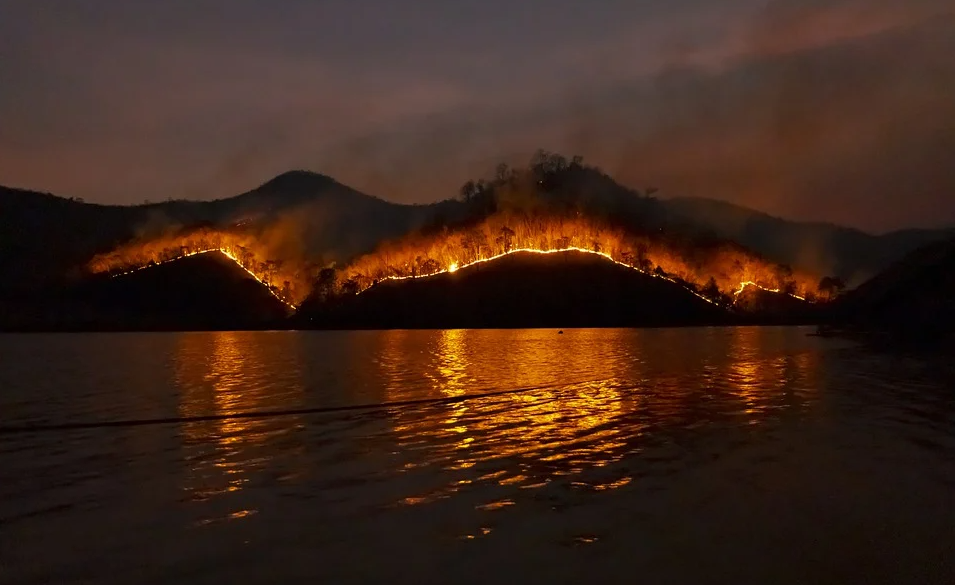

In [15]:
img = load_img('./splitted_data/train/train_fire/fire1.png')
img

In [24]:
#for idx, img in enumerate(img_fire):
x=img_to_array(img)  # 이미지를 array로 변경
x=x.reshape((1,)+x.shape) # img를 4차원으로 
x.shape

i=0
for batch in augGen.flow(x,batch_size=1, save_to_dir='plus', save_prefix="tir",save_format="png"):
    i+=1
    if i > 50:
        break

'''
for idx, img in enumerate(img_smoke):
    x=img_to_array(img)  # 이미지를 array로 변경 
    x=x.reshape((1,)+x.shape) # img를 4차원으로 
    x.shape
    
    i=0
    for batch in augGen.flow(x,batch_size=1, save_to_dir='/splitted_data/train/train-smoke', save_prefix="smoke",save_format="png"):
        i+=1
        if i > 50:
            break
'''

FileNotFoundError: [Errno 2] No such file or directory: 'plus\\tir_0_8738.png'

### 학습 데이터 전처리

In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('./splitted_data/train/',
                                                 target_size = (64,64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 39 images belonging to 2 classes.


In [7]:
training_set.class_indices

{'train-smoke': 0, 'train_fire': 1}

### 테스트 데이터 전처리

In [8]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('./splitted_data/val/',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 18 images belonging to 2 classes.


### CNN 모델 생성

In [9]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=7, activation='relu', input_shape=[64,64,3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [10]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        4736      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 256)               1

### 모델 학습

In [11]:
history = cnn.fit(x = training_set, epochs = 7 ,validation_data=test_set)

Epoch 1/7
2/2 [==============================] - 1s 486ms/step - loss: 0.6556 - accuracy: 0.5897 - val_loss: 1.1295 - val_accuracy: 0.5556
Epoch 2/7
2/2 [==============================] - 0s 433ms/step - loss: 0.4319 - accuracy: 0.8974 - val_loss: 0.5412 - val_accuracy: 0.6667
Epoch 3/7
2/2 [==============================] - 1s 439ms/step - loss: 0.7072 - accuracy: 0.6923 - val_loss: 0.3884 - val_accuracy: 0.7778
Epoch 4/7
2/2 [==============================] - 0s 181ms/step - loss: 0.3628 - accuracy: 0.8205 - val_loss: 0.9278 - val_accuracy: 0.5556
Epoch 5/7
2/2 [==============================] - 0s 180ms/step - loss: 0.7158 - accuracy: 0.5641 - val_loss: 0.4980 - val_accuracy: 0.7222
Epoch 6/7
2/2 [==============================] - 0s 178ms/step - loss: 0.3469 - accuracy: 0.8974 - val_loss: 0.3516 - val_accuracy: 0.9444
Epoch 7/7
2/2 [==============================] - 0s 407ms/step - loss: 0.3039 - accuracy: 0.8462 - val_loss: 0.3121 - val_accuracy: 0.8889


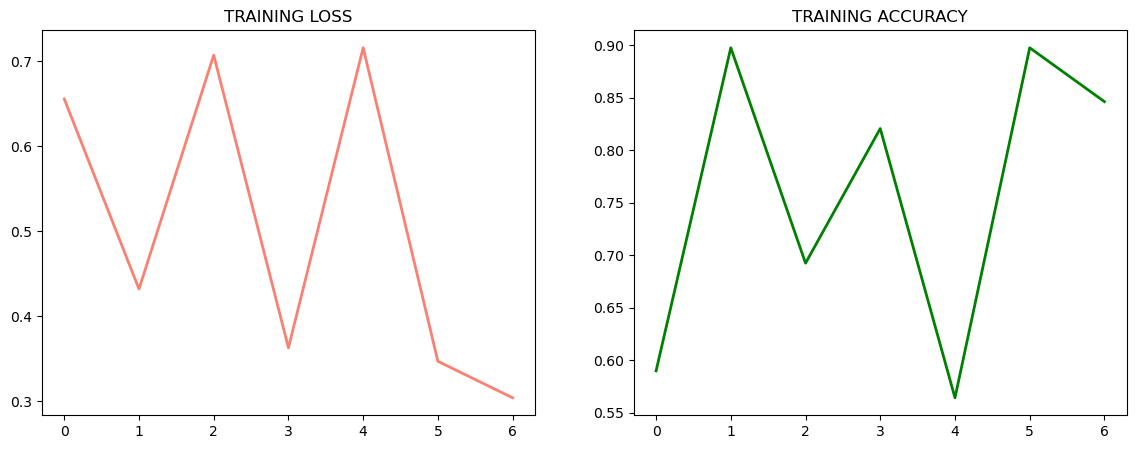

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'salmon',lw=2);
ax[1].plot(history.history['accuracy'], color= 'green',lw=2);